In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
import torchvision.transforms as T
from torch import nn
from torch import optim
from torchvision.models import resnet50
import torch.nn.functional as F
from torch.utils.data.dataloader import default_collate

sys.path.append("./libs/ACDA")
import Conv_DCFD as acda
from crowd import Crowd_sh

### Crowd counting
The paper uses ACDA trained with ImageNet as feature extractor and replace final linear layer with few standard transposed convolutional layers for recovering 

Note: wanted to use ShanghaiTech subset A dataset since it is smaller than UCF-QNRF, but couldn't find it. UCF-QNRF dataset available here:
https://www.crcv.ucf.edu/data/ucf-qnrf/

Using the ShanghaiTech subset A dataset since it is smaller than UCF-QNRF

Download link:
https://www.kaggle.com/datasets/tthien/shanghaitech

Paper that provided download link and the processing of the ShanghaiTech dataset (need to add citation to paper!)
https://github.com/cvlab-stonybrook/DM-Count
@inproceedings{wang2020DMCount,
  title={Distribution Matching for Crowd Counting},
  author={Boyu Wang and Huidong Liu and Dimitris Samaras and Minh Hoai},
  booktitle={Advances in Neural Information Processing Systems},
  year={2020},
}

For the crowd counting need to implement Resnet-18 (Ad-ResNet-s listed in Table A of appendix) but with out the first "max pool" layer and final "average pool" layer.
The Ad-ResNet-s network was very similar to ResNet-18, so the code for a ResNet-18 was used as a starting point and updated with the changes described in Appendix A.4 for crodwd counting.
Reference for how to implement ResNet-18:
https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch/notebook

ResNet original paper: https://arxiv.org/pdf/1512.03385.pdf


In [35]:
# base code for ResNet18 came from link below, modified based on Appendix A structure
# https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch?scriptVersionId=54460301&cellId=23

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, kernel_size_acda = None, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        if kernel_size is None:
            kernel_size = 3
        if kernel_size_acda:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=1)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.acda_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size_acda, stride=1, padding=1)
            self.acda_bn = nn.BatchNorm2d(in_channels)
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet_18(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.avgpool(x)
        # x = x.view(x.shape[0], -1)
        # x = self.fc(x)
        return x 

    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

class ResNet_18_ACDA(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(ResNet_18_ACDA, self).__init__()    
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        # # first max pooling layer removed
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2, kernel_size=1, kernel_size_acda=7)
        self.layer4 = self.__make_layer(256, 512, stride=2, kernel_size=1, kernel_size_acda=5)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride, kernel_size=None, kernel_size_acda=None):
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, 
                  stride=stride, kernel_size=kernel_size, kernel_size_acda=kernel_size_acda), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # YVETTE - last maxpool layer also removed
        # x = self.avgpool(x)
        # x = x.view(x.shape[0], -1)
        # x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

resNet = ResNet_18(3, 1000)
resNet_acda = ResNet_18_ACDA(3, 1000)

In [58]:
# Train network
mae = nn.L1Loss()
mse = nn.MSELoss()

def train(model, optimizer, train_data, num_epochs=2):
    loss_vals = []
    yvette = 0
    for _ in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        # for i, data in enumerate(train_data, 0):
        for i, (inputs, points, gt_discrete) in enumerate(train_data):
            # get the inputs
            gd_count = np.array([len(p) for p in points], dtype=np.float32)
            N = inputs.size(0)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # print('outputs shape: ', outputs.shape, ' gd_count shape: ', torch.from_numpy(gd_count).float().shape)
            # mae_loss = mae(outputs, torch.from_numpy(gd_count).float())
            mse_loss = mae(outputs.sum(1).sum(1).sum(1), torch.from_numpy(gd_count).float())
            mse_loss.backward()
            optimizer.step()

            pred_count = torch.sum(outputs.view(N, -1), dim=1).detach().cpu().numpy()
            pred_err = pred_count - gd_count
            if yvette < 5:
                print('running_loss = ', running_loss, ' mae_loss.item() = ', mse_loss.item(), ' pred_err = ', pred_err)
            yvette += 1

            # print statistics
            running_loss += mse_loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                loss_vals.append(running_loss / 10)
                running_loss = 0.0
    return loss_vals


In [ ]:
print(resNet_acda)

In [62]:
def train_collate(batch):
    transposed_batch = list(zip(*batch))
    images = torch.stack(transposed_batch[0], 0)
    points = transposed_batch[1]  # the number of points is not fixed, keep it as a list of tensor
    gt_discretes = torch.stack(transposed_batch[2], 0)
    return images, points, gt_discretes

# load the data
train_path = './data/ShanghaiTech/part_A/train_data/'
test_path = './data/ShanghaiTech/part_A/test_data/'

train_crowd = Crowd_sh(train_path, crop_size=112, method='train') # YVETTE - should that be 512 instead...?
test_crowd = Crowd_sh(test_path, crop_size=112, method='val')

# batch_size = 10
batch_size = 64
trainloader = torch.utils.data.DataLoader(train_crowd, batch_size=batch_size,
                                          shuffle=True, num_workers=0,
                                          collate_fn=train_collate,
                                          pin_memory=True)

testloader = torch.utils.data.DataLoader(test_crowd, batch_size=batch_size,
                                         shuffle=False, num_workers=0,
                                         collate_fn=default_collate,
                                         pin_memory=False)

number of img: 300
number of img: 182


In [63]:
resNet_optimizer = optim.SGD(resNet.parameters(), lr=0.001, momentum=0.9)
resNet_acda_optimizer = optim.SGD(resNet_acda.parameters(), lr=0.001, momentum=0.9)

# ResNet
epochs = 2
running_loss = train(resNet, resNet_optimizer, trainloader, epochs)
# test_results = test(resNet, testloader)

# ResNet + ACDA
# running_loss_acda = train(resNet_acda, resNet_acda_optimizer, trainloader, epochs)
# test_results_acda = test(resNet_acda, testloader)

running_loss =  0.0  mae_loss.item() =  14.354814529418945  pred_err =  [-1.1637337e+01  2.6089025e+01  1.3266768e+00 -1.3633568e+01
 -1.2634254e+01  7.3661537e+00  2.2825956e+00 -2.2561989e+00
 -2.2633432e+01  4.3621283e+00  5.4725137e+00 -7.6386337e+00
 -2.2636459e+01  5.3639879e+00  6.6622972e+00 -2.0821482e+01
 -6.5635056e+01 -3.0047808e+01 -5.9636322e+01  3.2021618e-01
  6.3629370e+00 -8.0623055e-01 -1.6795940e+00  1.3586330e+00
 -1.7634979e+01 -5.6325226e+00  4.4291472e+00 -9.7287397e+00
 -3.2639744e+01  4.3655329e+00 -9.2633194e+01  3.4177780e-02
 -1.6452866e+00 -2.4693108e+01  5.2611055e+00 -7.3675537e-01
 -1.3632218e+01 -3.0260720e+00 -5.5636635e+01 -2.3639269e+01
  2.3626394e+00  7.3648024e+00  3.3659172e+00  1.1677519e+01
  8.3298016e+00 -2.7633291e+01 -2.7634512e+01  7.3671455e+00
 -7.3990791e+01  8.3621626e+00  3.6419487e-01  4.6120896e+00
 -2.4449997e+00 -6.3956070e-01  7.3643398e+00 -4.3575764e+00
 -1.7632952e+01  7.3598986e+00  3.0514641e+00 -3.5633781e+01
  2.7885094e+

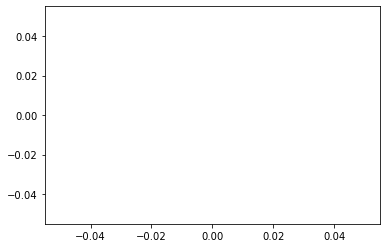

[]


In [61]:
plt.plot(running_loss)
plt.show()
print(running_loss)

In [ ]:
# Number of parameters in the models
print(resNet.parameters(), resNet_acda.parameters())
print(sum(p.numel() for p in resNet.parameters() if p.requires_grad))
print(sum(p.numel() for p in resNet_acda.parameters() if p.requires_grad))